# 🔥 День аналітики.
Модель вже навчена, ми її fine-tuned, подивились, куди вона дивиться. Тепер час розібрати, як вона поводиться під навантаженням, шумом і насправді.

### ✅ 1. Повторна Confusion Matrix
- Візьми модель після fine-tune

- Побудуй confusion matrix з підписами (назви класів)

- Візуалізуй через seaborn.heatmap або ConfusionMatrixDisplay

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchinfo import summary
import tifffile as tiff

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Розморожуємо останній блок (layer4) + fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False



model.fc = nn.Linear(in_features=512, out_features=5)  # Новий classifier
model = model.to(device)

print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)




Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [42]:
summary(model, input_size=(1, 3, 224, 224), device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

In [43]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_dir = 'hymenoptera_data/train'
test_dir = 'hymenoptera_data/val'

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)

num_classes = len(train_dataset.classes)
model = model.to(device)

epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, momentum=0.9)

def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true)

In [44]:
train_loss_values, train_acc_values = [], []
val_loss_values, val_acc_values = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    running_acc = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1) #CrossEntropyLoss
        running_acc += accuracy_fn(labels, preds)

    train_loss = total_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    model.eval()
    all_preds, all_labels = [], []
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            val_acc += accuracy_fn(labels, preds)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    val_loss_values.append(val_loss)
    val_acc_values.append(val_acc)

    print(f"Epoch {epoch+1}/{5} | "
    f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
    f"Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Accuracy: {acc:.4f}")

Epoch 1, Loss: 10.2024
Epoch 1/5 | Train Loss: 1.2753 Acc: 0.4773 | Test Loss: 0.0000 Acc: 0.5573
Accuracy: 0.5425
Epoch 2, Loss: 8.4902
Epoch 2/5 | Train Loss: 1.0613 Acc: 0.5133 | Test Loss: 0.0000 Acc: 0.5655
Accuracy: 0.5621
Epoch 3, Loss: 6.9957
Epoch 3/5 | Train Loss: 0.8745 Acc: 0.5977 | Test Loss: 0.0000 Acc: 0.6145
Accuracy: 0.6078
Epoch 4, Loss: 6.0172
Epoch 4/5 | Train Loss: 0.7521 Acc: 0.6695 | Test Loss: 0.0000 Acc: 0.7173
Accuracy: 0.7190
Epoch 5, Loss: 5.3845
Epoch 5/5 | Train Loss: 0.6731 Acc: 0.7125 | Test Loss: 0.0000 Acc: 0.7520
Accuracy: 0.7516


### ✅ 2. Classification Report
- Сформуй classification_report:
- Зверни увагу на precision/recall класів, які частіше плутаються



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
'''
all_labels — это истинные метки
all_preds — это предсказания модели
target_names — список классов (['ants', 'bees'])
'''


              precision    recall  f1-score   support

        ants       0.74      0.70      0.72        70
        bees       0.76      0.80      0.78        83

    accuracy                           0.75       153
   macro avg       0.75      0.75      0.75       153
weighted avg       0.75      0.75      0.75       153



🧠 **precision (точность):**
Из всех предсказанных как "bees", сколько действительно были bees.

Формула: precision = TP / (TP + FP)

🧠 **recall (полнота):**
Из всех настоящих bees, сколько модель правильно предсказала.

Формула: recall = TP / (TP + FN)

🧠 **f1-score:**
Усреднённое значение между точностью и полнотой. Сбалансированная метрика.

Формула: F1 = 2 * (precision * recall) / (precision + recall)

🧠 **support:**
Кол-во реальных примеров этого класса в выборке (ground truth).



🧮 Блоки ниже:

✅ **Accuracy:**
Общая точность = (все правильные предсказания) / (всего примеров)

✅ **Macro avg:**
Среднее по классам, без учёта количества примеров. Просто (class1_metric + class2_metric) / 2.

Полезно, когда у тебя несбалансированный датасет.

✅ **Weighted avg:**
Среднее с учетом веса каждого класса (т.е. support). Более честная метрика, если один класс сильно больше другого.



### ✅ 3. Аналіз помилок
- Знайди приклади неправильно класифікованих зображень

- Виведи хоча б 5 помилкових прикладів:

  - Зображення

  - True label

  - Predicted label

  - Можеш додати Grad-CAM до кожного

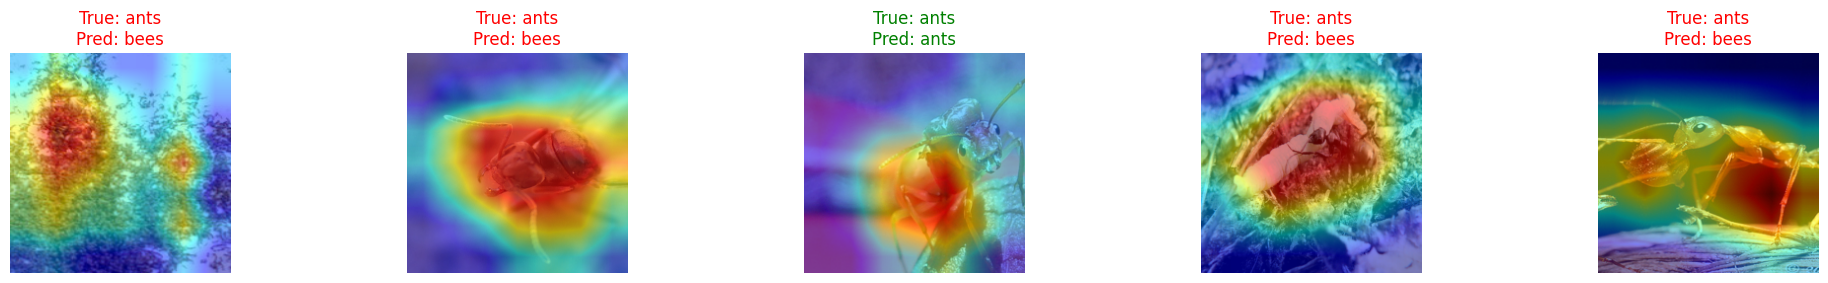

In [46]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def show_random_gradcam_grid(model, val_loader, class_names, device, num_images=20):
    model.eval()
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    all_images = []
    all_labels = []

    for imgs, lbls in val_loader:
        all_images.append(imgs)
        all_labels.append(lbls)
        if len(torch.cat(all_images)) >= num_images:
            break

    images = torch.cat(all_images)[:num_images]
    labels = torch.cat(all_labels)[:num_images]

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        input_tensor = images[i].unsqueeze(0).to(device)
        targets = [ClassifierOutputTarget(labels[i].item())]

        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        true_label = class_names[labels[i]]
        predicted_label = class_names[preds[i]]
        title_color = "green" if preds[i] == labels[i] else "red"
        
        ax = plt.subplot(4, 5, i + 1)
        ax.imshow(visualization)
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_random_gradcam_grid(model, val_loader, train_dataset.classes, device, 5)


### ✅ 4. Тест на робастність
- Візьми 10 зображень із валідації

- Додай до них Gaussian noise:
- Пропусти їх через модель
- Порівняй точність до/після

In [51]:
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.6928


In [ ]:
def add_noise(img, mean=0., std=0.1):
    noise = torch.randn_like(img) * std + mean
    noisy = img + noise
    return torch.clamp(noisy, 0., 1.)

Шум std=0.00 → Accuracy: 0.6405


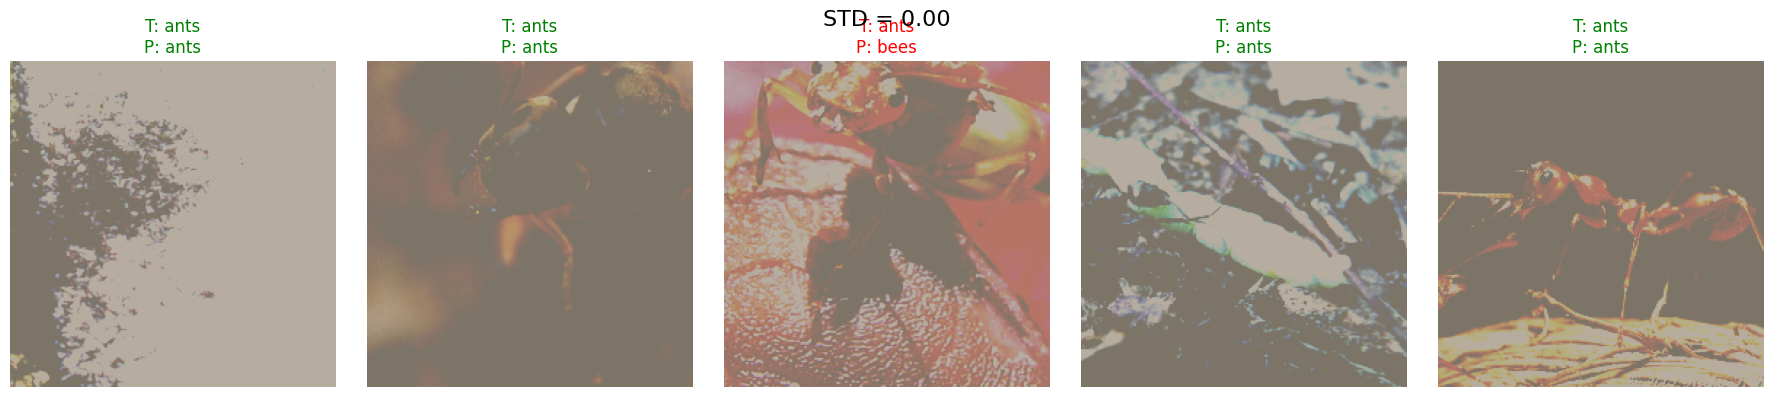

Шум std=0.05 → Accuracy: 0.6275


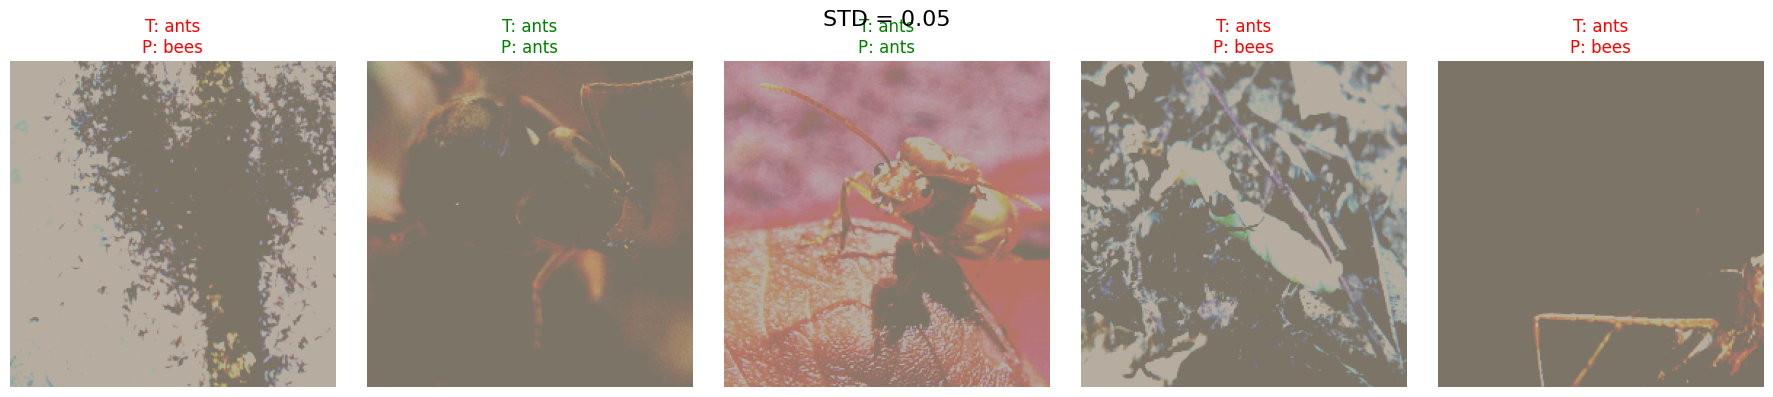

Шум std=0.10 → Accuracy: 0.5556


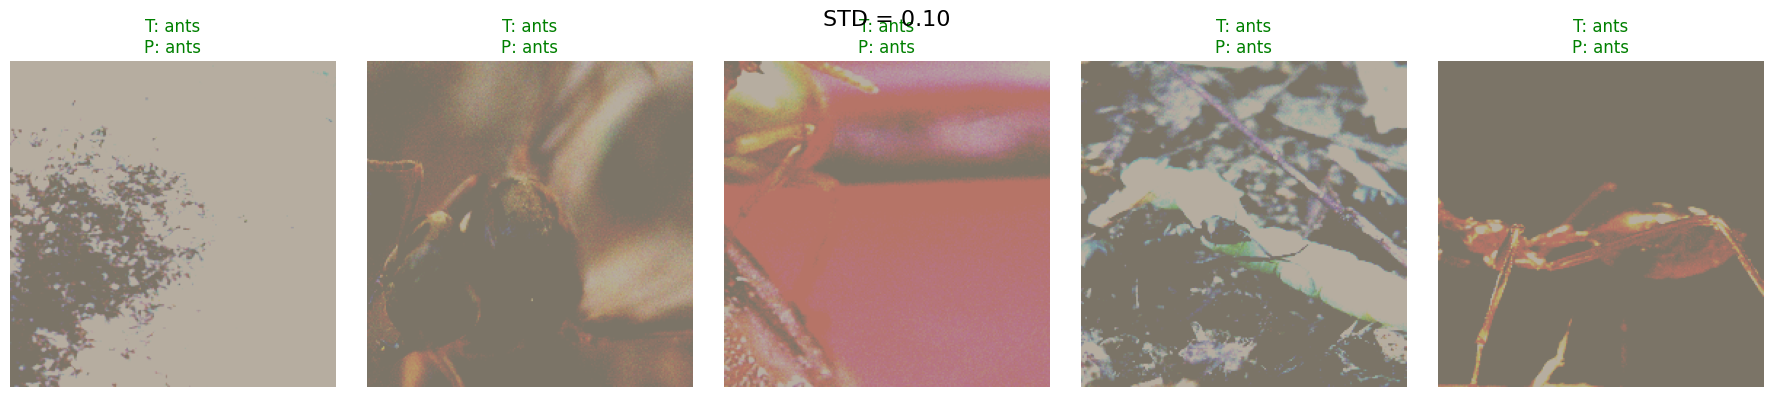

Шум std=0.20 → Accuracy: 0.4967


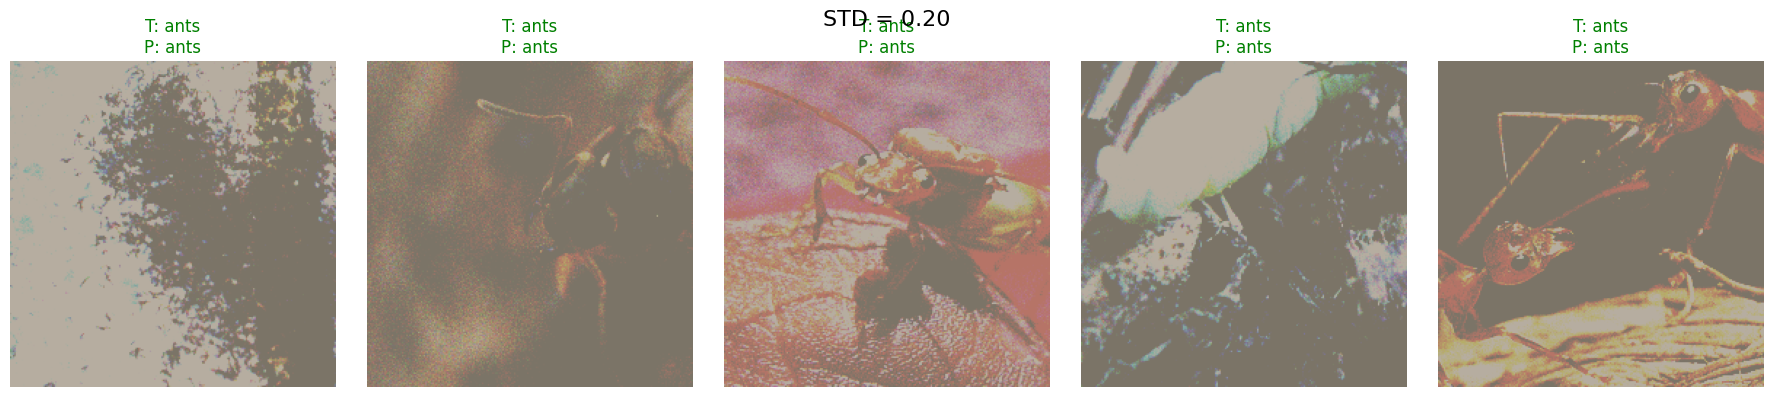

Шум std=0.30 → Accuracy: 0.5163


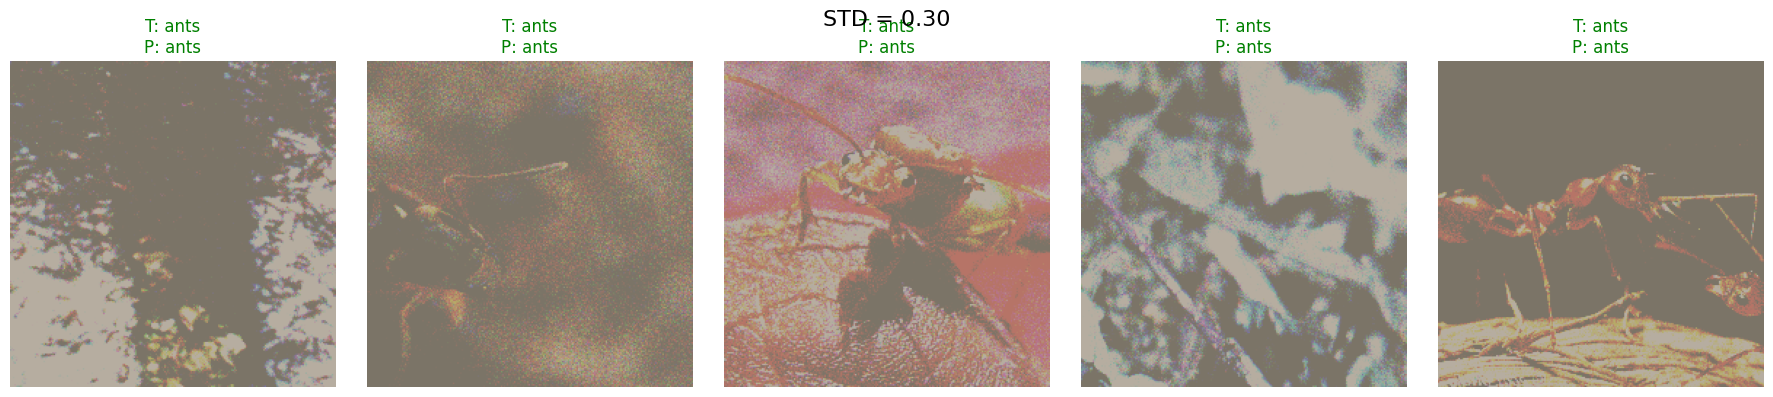

In [58]:
model.eval()

std_values = [0.0, 0.05, 0.1, 0.2, 0.3]
acc_values = []

for std in std_values:

    all_preds, all_labels = [], []
    sample_images, sample_labels = next(iter(val_loader))
    sample_images = sample_images[:5]
    sample_labels = sample_labels[:5]
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)

            images = add_noise(images, std=std)  

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    acc_values.append(acc)

    print(f"Шум std={std:.2f} → Accuracy: {acc:.4f}")

    fig, axs = plt.subplots(1, 5, figsize=(18, 4))
    fig.suptitle(f"STD = {std:.2f}", fontsize=16)

    noisy_samples = add_noise(sample_images.to(device), std=std)
    outputs = model(noisy_samples)
    preds = torch.argmax(outputs, dim=1)

    for i in range(5):
        img = noisy_samples[i].permute(1, 2, 0).cpu().numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        axs[i].imshow(img)
        true_cls = train_dataset.classes[sample_labels[i]]
        pred_cls = train_dataset.classes[preds[i]]
        color = "green" if sample_labels[i] == preds[i].cpu() else "red"
        axs[i].set_title(f"T: {true_cls}\nP: {pred_cls}", color=color)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


### ✅ 5. Графік зміни точності
- Побудуй графік: як змінюється точність, якщо збільшувати шум:

  - std = 0.0 → 0.05 → 0.1 → 0.2 → 0.3

  - accuracy vs std

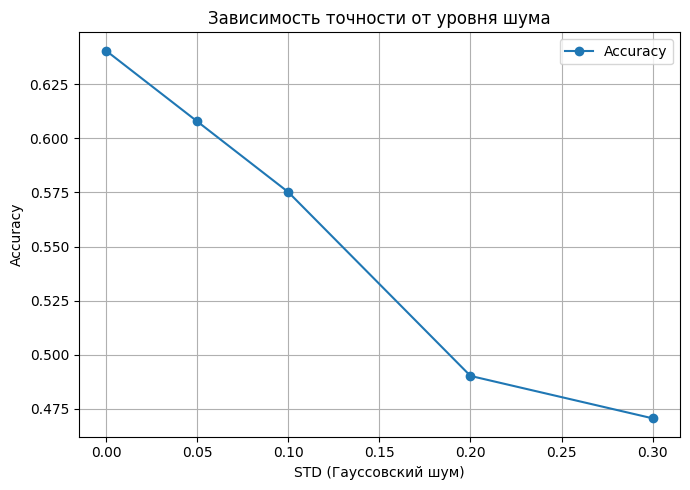

In [57]:
plt.figure(figsize=(7, 5))
plt.plot(std_values, acc_values, marker='o', label='Accuracy')
plt.xlabel("STD (Гауссовский шум)")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от уровня шума")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## ⭐ Підсумок
### 👉 Сформуй висновки:

- на яких класах модель найслабша?

                precision     recall  f1-score   support

        ants       0.74      0.70      0.72        70
        bees       0.76      0.80      0.78        83

        accuracy                       0.75       153
        macro avg  0.75      0.75      0.75       153
        weighted avg   0.75  0.75      0.75       153

смоттреть на f1-score 
Значит: на муравьях (ants) модель слабее, потому что:

*precision:* 0.74 — значит, она иногда принимает других за муравьев

*recall:*   0.70 — значит, не всех муравьев распознает

- які приклади найчастіше плутає?


*Recall*  = 0.70 для ants: из 100 настоящих муравьёв, 30 она ошибочно определила как "bees"

*Recall* = 0.80 для bees: из 100 настоящих пчёл, 20 она перепутала с "ants"


То есть модель чаще всего путает "ants" с "bees".


- наскільки вона робастна до шуму?

чем выше шум тем сильнее робастность...

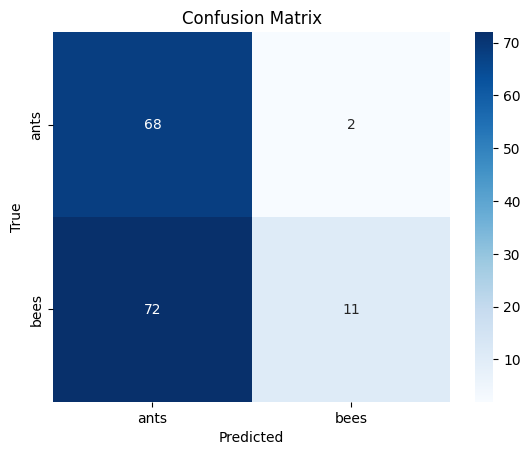

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
